Recurrent neural networks (RNNs) are widely used in various machine learning applications, including classification, translation, text generation, and time series analysis and so on. In this notebook, we will implement an example of an RNN and its variant, the GRU (Gated Recurrent Unit), for a character-level classification task.

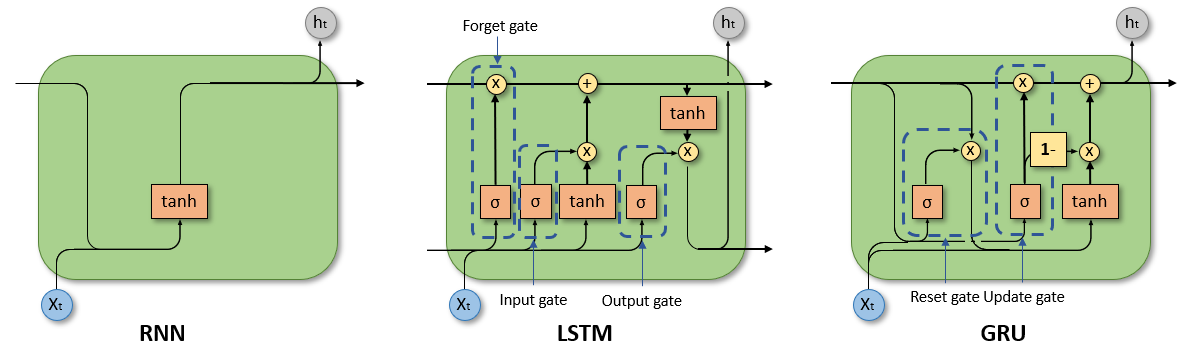

**Before you begin, please download the notebook and data https://download.pytorch.org/tutorial/data.zip, and update the folder_path variable to point to your data directory. If you are using Colab, you can upload the data to Google Drive, (e.g. upload it to /content/drive/My Drive/COMP551/ or other path) and use colab to run this notebook following the commands below.**

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# !ls /content/drive/My\ Drive/COMP551
folder_path = '/content/drive/My Drive/COMP551/data/names/'



A character-level RNN reads words as a series of characters - outputting a prediction and "hidden state" at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

# Preparing the Data

Included in the `data/names` directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, `{language: [names ...]}`. The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.

In [6]:
import glob
all_filenames = glob.glob(folder_path + '*.txt')  # get all txt files
print(all_filenames)
print(len(all_filenames))

['/content/drive/My Drive/COMP551/data/names/Russian.txt', '/content/drive/My Drive/COMP551/data/names/Vietnamese.txt', '/content/drive/My Drive/COMP551/data/names/Spanish.txt', '/content/drive/My Drive/COMP551/data/names/Irish.txt', '/content/drive/My Drive/COMP551/data/names/German.txt', '/content/drive/My Drive/COMP551/data/names/Japanese.txt', '/content/drive/My Drive/COMP551/data/names/Korean.txt', '/content/drive/My Drive/COMP551/data/names/French.txt', '/content/drive/My Drive/COMP551/data/names/Scottish.txt', '/content/drive/My Drive/COMP551/data/names/Italian.txt', '/content/drive/My Drive/COMP551/data/names/Dutch.txt', '/content/drive/My Drive/COMP551/data/names/Polish.txt', '/content/drive/My Drive/COMP551/data/names/Chinese.txt', '/content/drive/My Drive/COMP551/data/names/Portuguese.txt', '/content/drive/My Drive/COMP551/data/names/English.txt', '/content/drive/My Drive/COMP551/data/names/Arabic.txt', '/content/drive/My Drive/COMP551/data/names/Czech.txt', '/content/drive/

In [7]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)
print(all_letters)
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    s = s.lower()
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

57
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
slusarski


In [8]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)
print(all_categories)
print(category_lines['Russian'])

n_categories = 18
['Russian', 'Vietnamese', 'Spanish', 'Irish', 'German', 'Japanese', 'Korean', 'French', 'Scottish', 'Italian', 'Dutch', 'Polish', 'Chinese', 'Portuguese', 'English', 'Arabic', 'Czech', 'Greek']
['ababko', 'abaev', 'abagyan', 'abaidulin', 'abaidullin', 'abaimoff', 'abaimov', 'abakeliya', 'abakovsky', 'abakshin', 'abakumoff', 'abakumov', 'abakumtsev', 'abakushin', 'abalakin', 'abalakoff', 'abalakov', 'abaleshev', 'abalihin', 'abalikhin', 'abalkin', 'abalmasoff', 'abalmasov', 'abaloff', 'abalov', 'abamelek', 'abanin', 'abankin', 'abarinoff', 'abarinov', 'abasheev', 'abashev', 'abashidze', 'abashin', 'abashkin', 'abasov', 'abatsiev', 'abaturoff', 'abaturov', 'abaza', 'abaziev', 'abbakumov', 'abbakumovsky', 'abbasov', 'abdankkossovsky', 'abdeev', 'abdildin', 'abdrahimoff', 'abdrahimov', 'abdrahmanoff', 'abdrahmanov', 'abdrakhimoff', 'abdrakhimov', 'abdrakhmanoff', 'abdrakhmanov', 'abdrashitoff', 'abdrashitov', 'abdrazakoff', 'abdrazakov', 'abdulaev', 'abdulatipoff', 'abdul

Now we have `category_lines`, a dictionary mapping each category (language) to a list of lines (names). We also kept track of `all_categories` (just a list of languages) and `n_categories` for later reference.

In [9]:
print(category_lines['Italian'][:5])

['abandonato', 'abatangelo', 'abatantuono', 'abate', 'abategiovanni']


# Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [10]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [11]:
print(letter_to_tensor('J'))
print(letter_to_tensor('J').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])


In [12]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


# Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users tutorial](https://github.com/pytorch/tutorials/tree/2f3f3fa29a54a1fd9b8385a6e3a69a2f63ae6b3a)) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](https://i.imgur.com/Z2xbySO.png)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

## Manually testing the network

With our custom `RNN` class defined, we can create a new instance:

In [14]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

Remember that PyTorch modules operate on Variables rather than straight up Tensors.

In [15]:
input = letter_to_tensor('A')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use `line_to_tensor` instead of `letter_to_tensor` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [16]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)
print(input.size())
print(input[0].size())

output, next_hidden = rnn(input[0], hidden)
print(output)
print(output.size())

torch.Size([6, 1, 57])
torch.Size([1, 57])
tensor([[-2.8371, -2.7220, -2.7691, -2.9576, -2.8790, -2.9039, -2.9391, -2.9674,
         -2.9178, -2.9238, -2.9828, -2.8322, -2.7243, -2.8548, -2.7913, -3.0458,
         -3.0922, -2.9783]], grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 18])


As you can see the output is a `<1 x n_categories>` Tensor, where every item is the likelihood of that category (higher is more likely).

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [17]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    # print(top_n, top_i)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Vietnamese', tensor(1))


We will also want a quick way to get a training example (a name and its language):

In [18]:
import random

def random_training_pair():
    category = random.choice(all_categories)
    # print(category)
    line = random.choice(category_lines[category])
    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Irish / line = o'halloran
category = Irish / line = naoimhin
category = Czech / line = stegon
category = Spanish / line = reyes
category = Vietnamese / line = an
category = Spanish / line = ruiz
category = Arabic / line = mifsud
category = Greek / line = nomikos
category = Arabic / line = mustafa
category = Italian / line = serafini


# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

Or you could use CrossEntropyLoss and softmax (CrossRntropyLoss = LogSoftmax + NLLLoss).

In [19]:
criterion = nn.NLLLoss()

We will also create an "optimizer" which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.

In [20]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [21]:
def train_rnn(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()


Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` time steps, and take an average of the loss.

In [22]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train_rnn(category_tensor, line_tensor)
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.2113 rebka / Polish ✗ (Czech)
10000 10% (0m 23s) 0.4497 wojewodzki / Polish ✓
15000 15% (0m 36s) 1.0943 timkaev / Russian ✓
20000 20% (0m 48s) 1.4300 quraishi / Japanese ✗ (Arabic)
25000 25% (0m 59s) 4.6101 auyong / Arabic ✗ (Chinese)
30000 30% (1m 10s) 2.0620 rompaye / Irish ✗ (Dutch)
35000 35% (1m 21s) 1.2463 kober / German ✗ (Czech)
40000 40% (1m 33s) 2.3811 kaiser / Arabic ✗ (Czech)
45000 45% (1m 45s) 2.2848 otani / Italian ✗ (Japanese)
50000 50% (1m 55s) 0.3464 close / Greek ✓
55000 55% (2m 6s) 0.0436 michkov / Russian ✓
60000 60% (2m 18s) 1.3215 mendelssohn / German ✓
65000 65% (2m 29s) 0.1964 pokhilko / Russian ✓
70000 70% (2m 41s) 0.1383 rodrigues / Portuguese ✓
75000 75% (2m 52s) 1.8898 bawarin / French ✗ (Russian)
80000 80% (3m 3s) 0.9257 kraus / German ✓
85000 85% (3m 14s) 1.9391 chilar / Irish ✗ (Czech)
90000 90% (3m 26s) 0.0357 namiki / Japanese ✓
95000 95% (3m 37s) 0.9620 ho / Vietnamese ✗ (Korean)
100000 100% (3m 48s) 0.8056 d'angelo / Spanish ✗ (Itali

# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

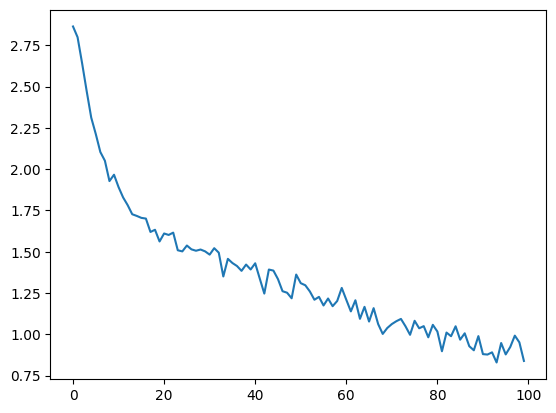

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

<ipython-input-24-35a44c8992dd>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-24-35a44c8992dd>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


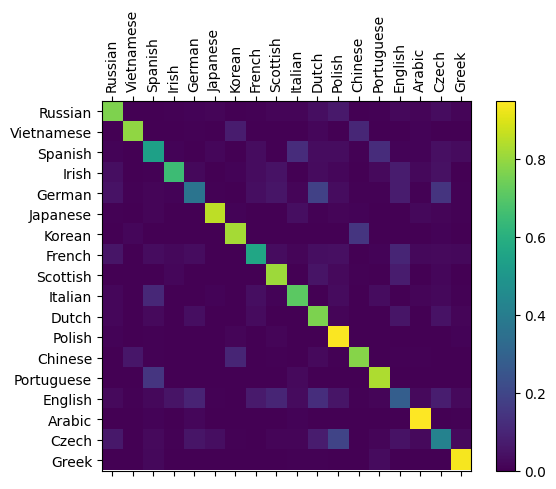

In [24]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

In [25]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(line_to_tensor(input_line))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.31) Czech
(-2.05) Polish
(-2.32) Russian

> Jackson
(-0.03) Scottish
(-3.72) English
(-6.61) Greek

> Satoshi
(-0.45) Italian
(-1.34) Japanese
(-3.09) Polish


**GRU network**





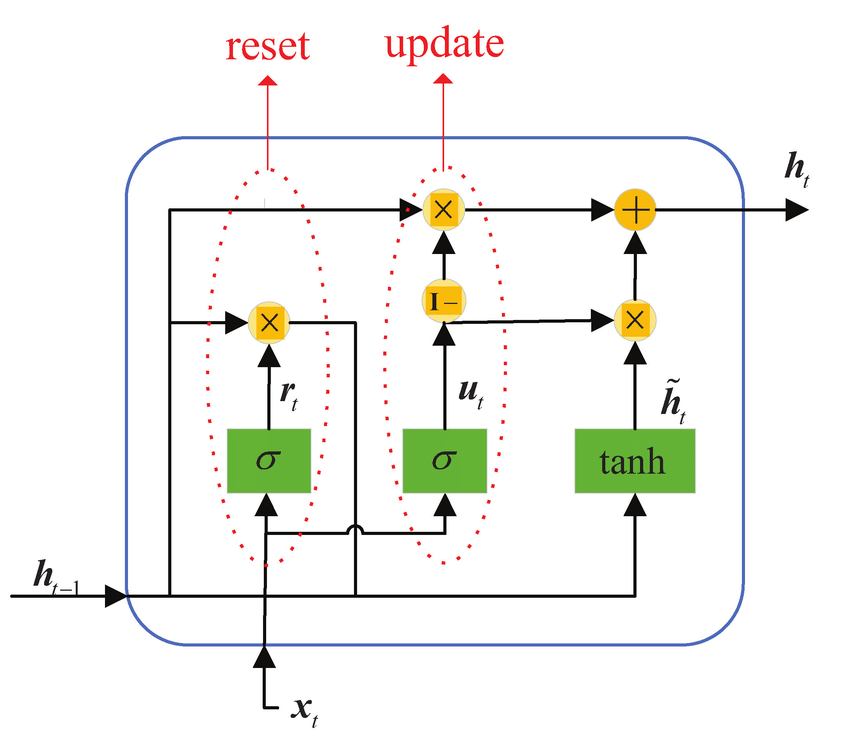

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # GRU gates
        self.i2h_z = nn.Linear(input_size, hidden_size)  # Input to update gate
        self.h2h_z = nn.Linear(hidden_size, hidden_size)  # Hidden to update gate

        self.i2h_r = nn.Linear(input_size, hidden_size)  # Input to reset gate
        self.h2h_r = nn.Linear(hidden_size, hidden_size)  # Hidden to reset gate

        self.i2h_h = nn.Linear(input_size, hidden_size)  # Input to new memory content
        self.h2h_h = nn.Linear(hidden_size, hidden_size)  # Hidden to new memory content

        # Output layer
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Update gate
        z_t = torch.sigmoid(self.i2h_z(input) + self.h2h_z(hidden))

        # Reset gate
        r_t = torch.sigmoid(self.i2h_r(input) + self.h2h_r(hidden))

        # New memory content
        h_tilde = torch.tanh(self.i2h_h(input) + r_t * self.h2h_h(hidden))

        # Final hidden state
        hidden = (1 - z_t) * hidden + z_t * h_tilde

        # Output
        output = self.h2o(hidden)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Example: Testing the GRU
n_hidden = 128
n_letters = 57  # Example number of input features (e.g., number of possible characters)
n_categories = 18  # Example number of output classes (e.g., number of categories)

# Initialize the GRU
gru = GRU(n_letters, n_hidden, n_categories)


# Test the GRU with a single letter ('A')
input = letter_to_tensor('A')  # Single letter input
hidden = gru.init_hidden()  # Initialize hidden state

# Forward pass for a single letter
output, next_hidden = gru(input, hidden)
print('Single letter output size =', output.size())

# Test the GRU with a line ('Albert')
input = line_to_tensor('Albert')  # Line input (sequence of letters)
hidden = gru.init_hidden()  # Reset the hidden state

# Forward pass for the first letter in the line
output, next_hidden = gru(input[0], hidden)  # Process first letter in the sequence
print('First letter output for "Albert":', output)

# Process the entire line ('Albert') letter by letter
for i in range(input.size()[0]):
    output, hidden = gru(input[i], hidden)

print('Final output after processing the line "Albert":', output)


Single letter output size = torch.Size([1, 18])
First letter output for "Albert": tensor([[-2.9038, -2.9082, -2.9446, -2.9521, -2.9342, -2.8490, -2.9109, -2.8739,
         -2.8732, -2.8738, -2.8914, -2.8021, -2.8691, -2.8507, -2.9400, -2.8250,
         -2.9261, -2.9141]], grad_fn=<LogSoftmaxBackward0>)
Final output after processing the line "Albert": tensor([[-2.9520, -2.8810, -2.9605, -2.9556, -2.9416, -2.8158, -2.8880, -2.8965,
         -2.8498, -2.9064, -2.9463, -2.7673, -2.8779, -2.8647, -2.9779, -2.7486,
         -2.9354, -2.8980]], grad_fn=<LogSoftmaxBackward0>)


In [29]:
criterion_gru = nn.NLLLoss()
learning_rate = 0.008 # If you set this too high, it might explode. If too low, it might not learn
optimizer_gru = torch.optim.SGD(gru.parameters(), lr=learning_rate)


5000 5% (0m 37s) 0.1911 molyavin / Russian ✓
10000 10% (1m 6s) 2.2628 dazai / Arabic ✗ (Japanese)
15000 15% (1m 38s) 0.7685 winther / German ✓
20000 20% (2m 11s) 0.1104 so / Korean ✓
25000 25% (2m 40s) 0.6148 silva / Portuguese ✓
30000 30% (3m 9s) 0.0595 poplawski / Polish ✓
35000 35% (3m 38s) 0.1951 rinaldi / Italian ✓
40000 40% (4m 7s) 1.5994 koury / English ✗ (Arabic)
45000 45% (4m 48s) 0.1114 awad / Arabic ✓
50000 50% (5m 18s) 0.0020 kunomasu / Japanese ✓
55000 55% (5m 47s) 0.5082 chang / Korean ✓
60000 60% (6m 17s) 0.0640 ferguson / Scottish ✓
65000 65% (6m 46s) 0.1850 cisternino / Italian ✓
70000 70% (7m 16s) 0.1161 sauvageau / French ✓
75000 75% (7m 45s) 1.1566 linville / French ✓
80000 80% (8m 16s) 0.4230 do / Vietnamese ✓
85000 85% (8m 46s) 0.6446 neil / Irish ✓
90000 90% (9m 16s) 0.5395 reinder / Dutch ✓
95000 95% (9m 45s) 0.2176 chlebek / Polish ✓
100000 100% (10m 14s) 0.2316 wirnhier / German ✓


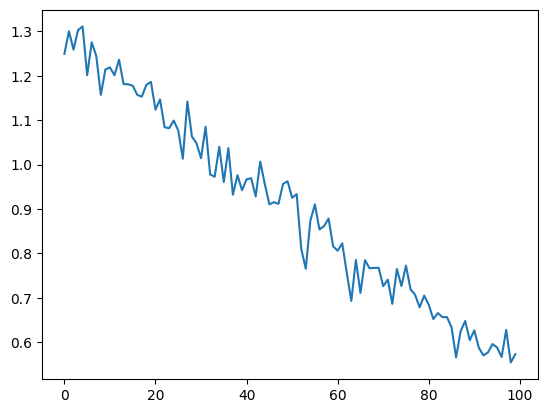

In [30]:
def train_gru(category_tensor, line_tensor):
    gru.zero_grad()
    hidden = gru.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion_gru(output, category_tensor)
    loss.backward()

    optimizer_gru.step()

    return output, loss.item()

import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train_gru(category_tensor, line_tensor)
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


plt.figure()
plt.plot(all_losses)


<ipython-input-31-574ccdd84e8b>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-31-574ccdd84e8b>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


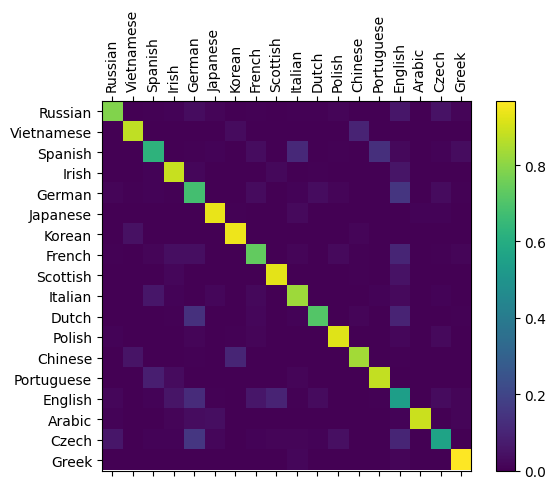

In [31]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = gru.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Exercises

* Try with a different dataset of line -> category, for example:
    * Any word -> language
    * First name -> gender
    * Character name -> writer
    * Page title -> blog or subreddit
* Get better results with a bigger and/or better shaped network
    * Add more linear layers
    * Try the `nn.LSTM` and `nn.GRU` layers
    * Combine multiple of these RNNs as a higher level network